In [1]:
import matplotlib.pyplot as plt
import numpy as np

from networks import *
from model import model, configurator, posterior_configurator, constrain_parameters, constrained_parameter_names
from cmdstanpy import CmdStanModel
from bayesflow.trainers import Trainer
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.networks import InvertibleNetwork, SequenceNetwork
from logging import getLogger

import bayesflow.diagnostics as diagnostics

stan_logger = getLogger("cmdstanpy")
stan_logger.disabled = True

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 100, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [2]:
stan_model = CmdStanModel(stan_file="stan-model.stan")

In [3]:
smoothing = Trainer(
    amortizer=MixtureAmortizer(inference_net=Smoothing(n_classes=2)),
    generative_model=model,
    configurator=configurator,
    checkpoint_path="checkpoints/smoothing"
)

INFO:root:Loaded loss history from checkpoints/smoothing/history_60.pkl.
INFO:root:Networks loaded from checkpoints/smoothing/ckpt-60
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [4]:
posterior = Trainer(
    amortizer=AmortizedPosterior(
    inference_net=InvertibleNetwork(num_params=4, num_coupling_layers=10, coupling_design="spline"),
    summary_net=SequenceNetwork(summary_dim=12, num_conv_layers=4, bidirectional=True),
    summary_loss_fun = "MMD"),
    generative_model=model,
    configurator=posterior_configurator,
    checkpoint_path="checkpoints/posterior"
)

INFO:root:Loaded loss history from checkpoints/posterior/history_100.pkl.
INFO:root:Networks loaded from checkpoints/posterior/ckpt-100
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


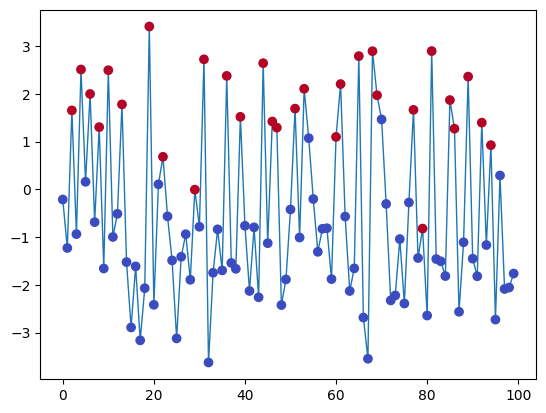

In [5]:
df = model(1)
df_smoothing = configurator(df)
df_posterior = posterior_configurator(df)

observables = df_smoothing['observables'][0,...,0]
latents = df_smoothing['latents'][0,...,1]

stan_df = {
    "n_obs": 100,
    "y": observables,
    "alpha": [[2, 2], [2, 2]]
}


plt.plot(observables, linewidth=1, zorder=-1)
f=plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [6]:
stan_fit = stan_model.sample(stan_df, show_progress=False)
print(stan_fit.diagnose())

Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptvrjay4f/stan-modelxi7mdz22/stan-model-20240625171639_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptvrjay4f/stan-modelxi7mdz22/stan-model-20240625171639_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptvrjay4f/stan-modelxi7mdz22/stan-model-20240625171639_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmptvrjay4f/stan-modelxi7mdz22/stan-model-20240625171639_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [7]:
stan_posterior = stan_fit.draws_pd(vars = ["transition_matrix", "mu"])
stan_posterior = np.array(stan_posterior)
stan_posterior = stan_posterior[:, (0, 3, 4, 5)]

In [8]:
bf_posterior_unconstrained = posterior.amortizer.sample(df_posterior, n_samples=4000)
bf_posterior = constrain_parameters(bf_posterior_unconstrained)

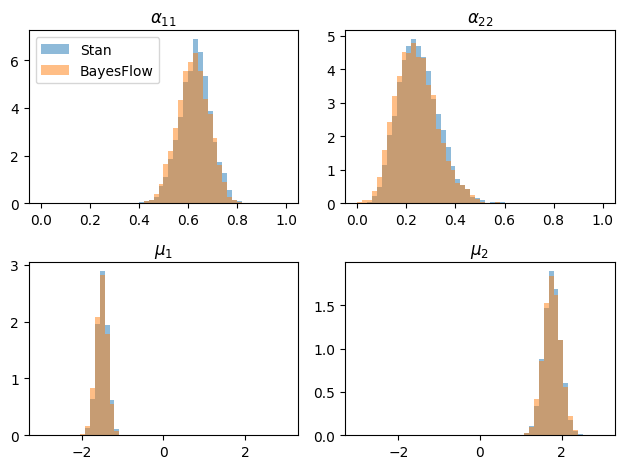

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2)
axs = axs.flatten()

bins = [
    np.linspace(0, 1, 51),
    np.linspace(0, 1, 51),
    np.linspace(-3, 3, 51),
    np.linspace(-3, 3, 51)
]
for i, par in enumerate(constrained_parameter_names):
    axs[i].hist(stan_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="Stan")
    axs[i].hist(bf_posterior[:,i], bins=bins[i], alpha = 0.5, density=True, label="BayesFlow")
    axs[i].set_title(par)

axs[0].legend()
fig.tight_layout()

In [10]:
stan_smoothing = stan_fit.draws_pd(vars=['smoothing'])
stan_smoothing = stan_smoothing.iloc[:, stan_df['n_obs']:]
stan_smoothing = np.array(stan_smoothing)

In [11]:
bf_smoothing = smoothing.amortizer.sample(df_smoothing['observables'], bf_posterior_unconstrained)

In [12]:
bf_smoothing=bf_smoothing[...,1]

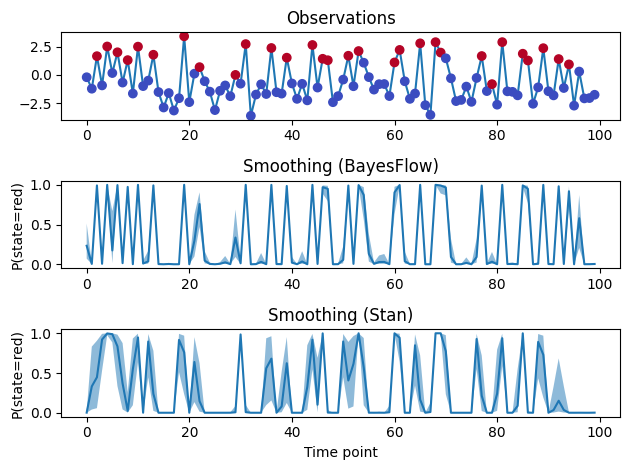

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(bf_smoothing, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(bf_smoothing, q=0.01, axis=0),
    np.quantile(bf_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax2.set_title("Smoothing (BayesFlow)")
ax2.set_ylabel("P(state=red)")

ax3.plot(range(len(observables)), np.median(stan_smoothing, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_smoothing, q=0.01, axis=0),
    np.quantile(stan_smoothing, q=0.99, axis=0),
    alpha=0.5
)
ax3.set_title("Smoothing (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
fig.tight_layout()